# TMDB Movie Data Exploration
The goal of the project is to derive insights on the TMDB movie datset and perform regression models to predict revenue of the movie. This model could be leveraged by production companies for making go/no-go screening decisions.

TMDB Movie Dataset available on Kaggle. Link: https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline
plt.style.use('ggplot')
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mayura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
from urllib.request import urlopen
from PIL import Image
import time

In [3]:

import os
def text_to_dict(df):
    for column in dict_columns: 
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

## 1 Load TMDB datset

In [4]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [5]:
LOST_COLUMNS = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','aspect_ratio',
    'cast_total_facebook_likes','color','content_rating','director_facebook_likes', 'facenumber_in_poster',
    'movie_facebook_likes','movie_imdb_link','num_critic_for_reviews','num_user_for_reviews']

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {'budget': 'budget','genres': 'genres','revenue': 'gross','title': 'movie_title',
    'runtime': 'duration','original_language': 'language', 'keywords': 'plot_keywords','vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

## 1.1 Extracting Strings from columns - nested JSON
The Movie and credit data contain columns of nested JSON which need to be split into separate columns for accurate analysis.

In [6]:
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['company'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director'] = credits['crew'].apply(get_director)
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()


In [8]:

credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_movies = convert_to_original_format(movies, credits)
print('Shape:',df_movies.shape)

tab_info=pd.DataFrame(df_movies.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_movies.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_movies.isnull().sum()/df_movies.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Shape: (4803, 24)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,year,country,company,director
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object
null values,0,0,3091,0,0,0,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,351,30
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,7.30793,0.62461


## 1.2 Exploratory Analysis

In [9]:
df_movies.head(5)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,year,country,company,director
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,Ingenious Film Partners,James Cameron
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Walt Disney Pictures,Gore Verbinski
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Columbia Pictures,Sam Mendes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Legendary Pictures,Christopher Nolan
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Walt Disney Pictures,Andrew Stanton


###  1.2.1 Missing Values 

In [10]:
missing_df = df_movies.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_movies.shape[0] 
                                - missing_df['missing_count']) / df_movies.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,company,351,92.692067
3,country,174,96.377264
4,director,30,99.375390
5,overview,3,99.937539
6,duration,2,99.958359
7,year,1,99.979180
8,release_date,1,99.979180
9,production_companies,0,100.000000


In [11]:
def word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
                
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

### 1.2.2 Genre Extraction and Analysis per year

In [12]:
g_labels = set()
for s in df_movies['genres'].str.split('|').values:
    g_labels = g_labels.union(set(s))

In [13]:
occurences, dum = word(df_movies, 'genres', g_labels)
occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [14]:
occurences = [x for x in occurences if x[0]]
occurences

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894],
 ['Adventure', 790],
 ['Crime', 696],
 ['Science Fiction', 535],
 ['Horror', 519],
 ['Family', 513],
 ['Fantasy', 424],
 ['Mystery', 348],
 ['Animation', 234],
 ['History', 197],
 ['Music', 185],
 ['War', 144],
 ['Documentary', 110],
 ['Western', 82],
 ['Foreign', 34],
 ['TV Movie', 8]]

### Keywords

In [15]:
set_keywords = set()
for liste_keywords in df_movies['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

set_keywords.remove('')

In [16]:
keyword_occurences, dum = word(df_movies, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

(-0.5, 999.5, 299.5, -0.5)

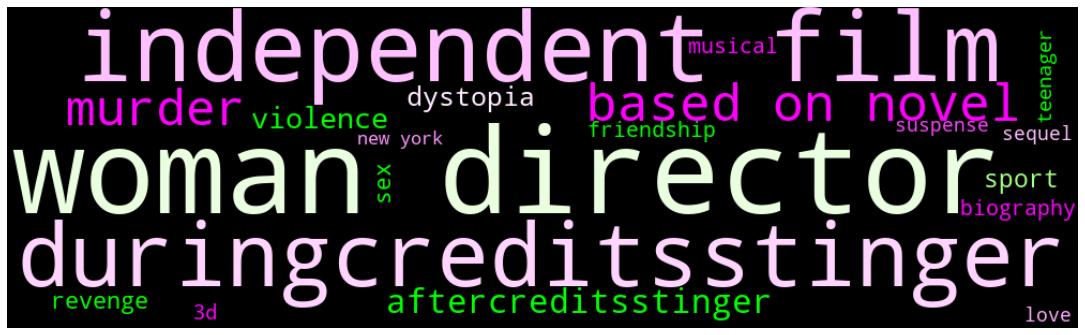

In [17]:

def random_color(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(200.0 * tone / 100.0)
    s = int(200.0 * 255.0 / 100.0)
    l = int(200.0 * float(random_state.randint(20, 70)) / 100.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_occurences[0:20]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words

wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')


In [18]:
df_movies['genres']

0       Action|Adventure|Fantasy|Science Fiction
1                       Adventure|Fantasy|Action
2                         Action|Adventure|Crime
3                    Action|Crime|Drama|Thriller
4               Action|Adventure|Science Fiction
                          ...                   
4798                       Action|Crime|Thriller
4799                              Comedy|Romance
4800               Comedy|Drama|Romance|TV Movie
4801                                            
4802                                 Documentary
Name: genres, Length: 4803, dtype: object

In [19]:
def parse(col):

    # pandas series to list
    entries = list(col)
    
    # handling "|" separator and removing duplicates
    collect = [] #this will contain all the unique genres
    
    for entry in entries:
        for _ in entry.split("|"):
            if _ not in collect:
                collect.append(_)
    return(collect)

In [20]:
parse(df_movies['genres'])

['Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'TV Movie',
 '']

In [21]:
year = df_movies['year'].unique()

In [22]:
n_df = {key:[] for key in parse(df_movies['genres'])}


In [23]:
n_df['year'] = year


In [24]:
for y in year: # to get genre count for each year
    
    #subsetting for corresponding year
    y_df_movies = df_movies[df_movies['year'] == y]
    
    # converting pandas series to column
    genres_i1 = list(y_df_movies['genres'])  
    genres_f1 = [] # this will contain all the genres that we see for a given year(with repetition and "|" separator)
    
    for genre in genres_i1: # for splitting every entry in y_df[genres] with separator as "|" 
        for i in genre.split("|"):
            genres_f1.append(i)

    n_list = Counter(genres_f1) # occurrence of each genre in a year
    for genre in parse(df_movies['genres']): #this will create occurrence of each genre in a year
        if genre not in genres_f1:
            n_df[genre].append(0)
        else:
            n_df[genre].append(n_list[genre])

In [25]:
n_df = pd.DataFrame(n_df, index = n_df['year'])

In [26]:
n_df.columns
del(n_df['year'])

In [27]:

n_df.head()

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,
2009.0,51,36,22,32,32,122,59,15,28,0,97,57,30,28,8,4,11,5,4,0,0
2007.0,44,25,19,13,28,97,53,10,20,5,67,37,27,17,9,2,11,7,3,0,0
2015.0,46,35,10,28,26,95,67,13,17,7,52,23,33,20,9,2,8,7,0,0,7
2012.0,43,25,19,22,27,79,58,13,17,2,80,39,33,8,4,2,7,9,1,2,2
2010.0,49,30,21,19,30,115,56,13,29,5,87,45,27,17,8,6,2,7,1,0,1


What this dataframe shows?

Let's see first row. If there are n number of movies released in 1960, then entries corresponding to 2016 shows how many times
each genre appeared in 2016.
Let's see this numerically:

In [28]:
total_occ = n_df.loc[2016].sum()
total_occ

245

In [29]:
action_occ = n_df.loc[2016,'Action']
action_occ

39

In [30]:
df1 = {key:[] for key in parse(df_movies['genres'])}


In [31]:
df1['year'] = year


In [32]:
for index,row in n_df.iterrows():
    for genre in list(n_df.columns):
        df1[genre].append((100*row[genre]/sum(row)))

In [33]:
df1 = pd.DataFrame(df1)
df1.head(5)

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,,year
0,7.956318,5.616225,3.432137,4.992200,4.992200,19.032761,9.204368,2.340094,4.368175,0.000000,15.132605,8.892356,4.680187,4.368175,1.248050,0.624025,1.716069,0.780031,0.624025,0.000000,0.000000,2009.0
1,8.906883,5.060729,3.846154,2.631579,5.668016,19.635628,10.728745,2.024291,4.048583,1.012146,13.562753,7.489879,5.465587,3.441296,1.821862,0.404858,2.226721,1.417004,0.607287,0.000000,0.000000,2007.0
2,9.108911,6.930693,1.980198,5.544554,5.148515,18.811881,13.267327,2.574257,3.366337,1.386139,10.297030,4.554455,6.534653,3.960396,1.782178,0.396040,1.584158,1.386139,0.000000,0.000000,1.386139,2015.0
3,8.739837,5.081301,3.861789,4.471545,5.487805,16.056911,11.788618,2.642276,3.455285,0.406504,16.260163,7.926829,6.707317,1.626016,0.813008,0.406504,1.422764,1.829268,0.203252,0.406504,0.406504,2012.0
4,8.626761,5.281690,3.697183,3.345070,5.281690,20.246479,9.859155,2.288732,5.105634,0.880282,15.316901,7.922535,4.753521,2.992958,1.408451,1.056338,0.352113,1.232394,0.176056,0.000000,0.176056,2010.0


In [34]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.columns

Index(['year', 'Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', 'TV Movie', ''],
      dtype='object')

### Top five Genre 

In [35]:
top = []
for _ in df1.columns[1:]:
    top.append(np.mean(df1[_]))
    top.sort(reverse = True)
top[:5]

[23.322481660501555,
 11.04956668878027,
 10.577991196658129,
 7.897038473855781,
 7.167131924510249]

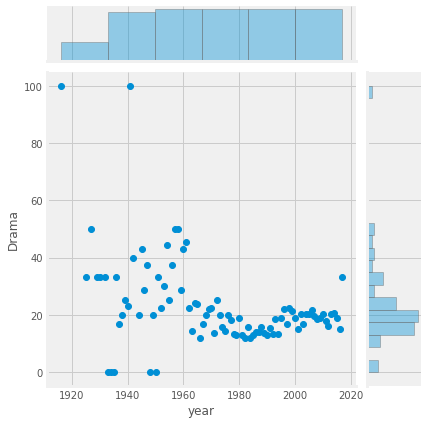

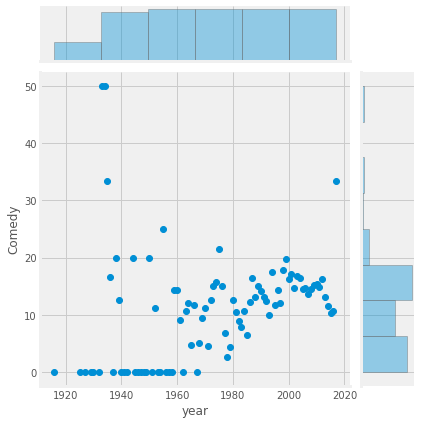

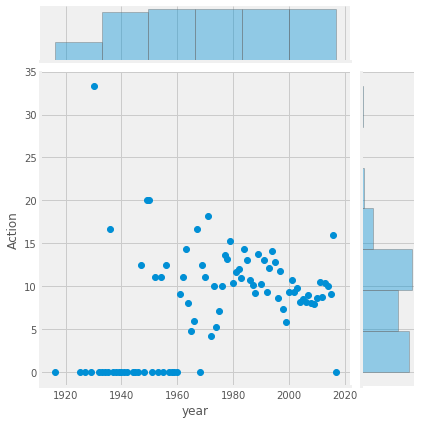

In [36]:
import seaborn as sns
g = ['Drama','Comedy','Action']
for genre in g:
    sns.jointplot(x=df1['year'], y= df1[genre]);
    #plot = sns.regplot(y = new_df1[genre], x = new_df1['year'], lowess = True);
#plot.set_ylabel("");
#plot.axvline(x = 2016, color = 'black', alpha = 1.0);


## 1.2.3  Comparing Revenue with vote_count, popularity and runtime

GGPlot using rpy2 for better visual analysis.
Here the plot analysis shows that the highly popular movies with high revenue has duration of 1hr40 mins

In [37]:
import pandas as pd
import rpy2
from plotnine import *
# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline
# we need to activate the automatic conversion for pandas

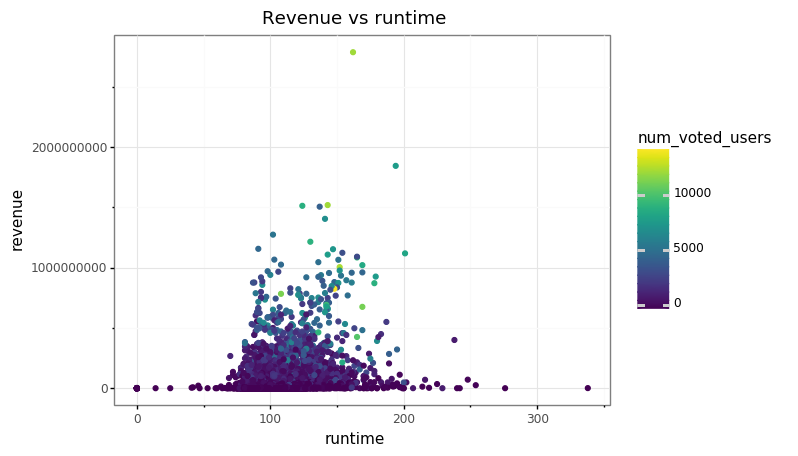

<ggplot: (131809034290)>

In [38]:

ggplot(aes(x='duration', y='gross', color='num_voted_users'), data=df_movies) +\
    geom_point() +\
    theme_bw() +\
    xlab("runtime") +\
    ylab("revenue") +\
    ggtitle("Revenue vs runtime")


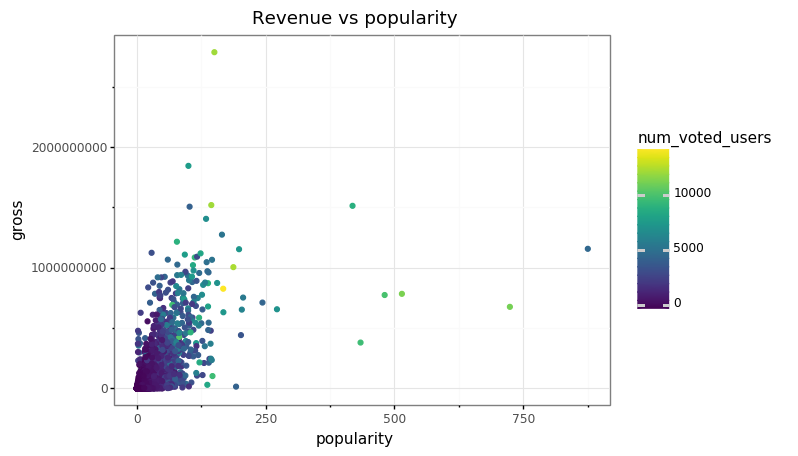

<ggplot: (131809049036)>

In [39]:

ggplot(aes(x='popularity', y='gross', color='num_voted_users'), data=df_movies) +\
    geom_point() +\
    theme_bw() +\
    xlab("popularity") +\
    ylab("gross") +\
    ggtitle("Revenue vs popularity")

The plot analysis shows that the top movies that have high revenue have high popularity between the frequency of 500-750 and votes from 5000-10000 

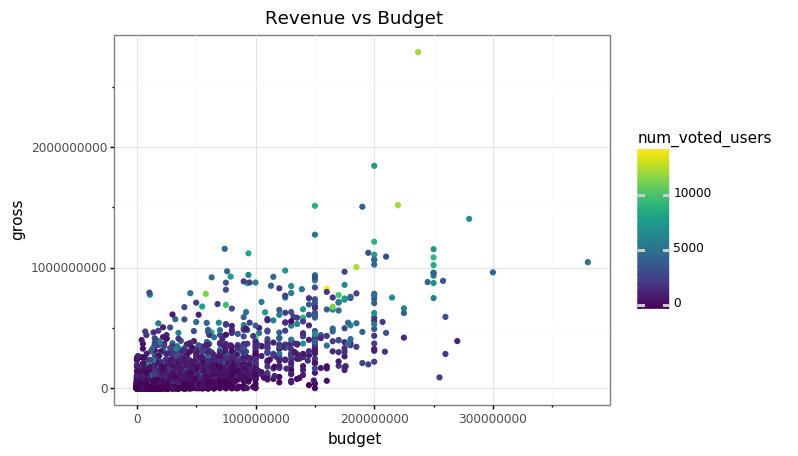

<ggplot: (131807645595)>

In [40]:
ggplot(aes(x='budget', y='gross', color='num_voted_users'), data=df_movies) +\
    geom_point() +\
    theme_bw() +\
    xlab("budget") +\
    ylab("gross") +\
    ggtitle("Revenue vs Budget")

The plot analysis shows that the budget directly affects the revenue.
If the movies is released with high budget the revenue is accordingly high

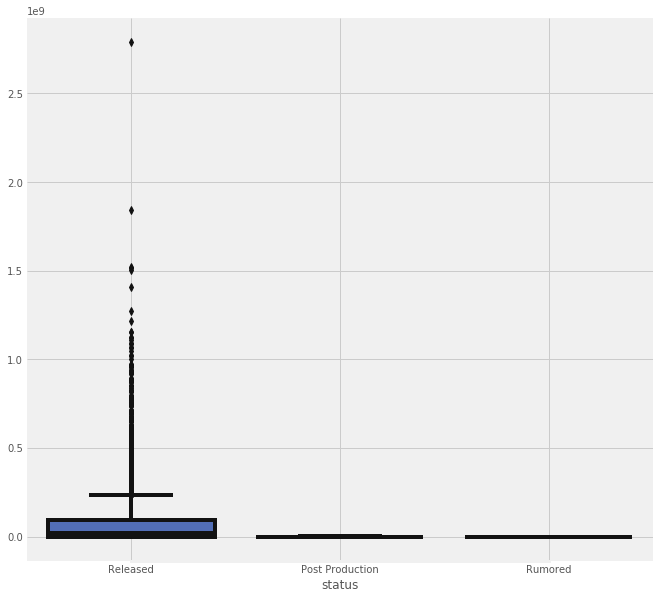

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
#ax = sns.boxplot(x="open_gross", y="genre", data=df0, palette=sns.light_palette((210, 90, 60), input="husl"))
#ax = sns.boxplot(x="open_gross", y="genre", data=df0, palette="GnBu_d")
ax = sns.boxplot(x="status", y="gross", data=df_movies, palette="icefire")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.show()

## 1.2.4 Caluclating movies with high profit and low profit

 the budget of high amd low profit movie is nearly 2 million.

In [42]:
df_movies['Profit'] = df_movies['gross'] - df_movies['budget']
X=df_movies['Profit']

In [43]:
def find_minmax(x):
    #use the function 'idmin' to find the index of lowest profit movie.
    min_index = df_movies[x].idxmin()
    #use the function 'idmax' to find the index of Highest profit movie.
    high_index = df_movies[x].idxmax()
    high = pd.DataFrame(df_movies.loc[high_index,:])
    low = pd.DataFrame(df_movies.loc[min_index,:])
    
    #print the movie with high and low profit
    print("Movie Which Has Highest "+ x + " : ",df_movies['original_title'][high_index])
    print("Movie Which Has Lowest "+ x + "  : ",df_movies['original_title'][min_index])
    return pd.concat([high,low],axis = 1)

#call the find_minmax function.
find_minmax('Profit')

Movie Which Has Highest Profit :  Avatar
Movie Which Has Lowest Profit  :  The Lone Ranger


,0,13
budget,237000000,255000000
genres,Action|Adventure|Fantasy|Science Fiction,Action|Adventure|Western
homepage,http://www.avatarmovie.com/,http://disney.go.com/the-lone-ranger/
id,19995,57201
plot_keywords,culture clash|future|space war|space colony|so...,texas|horse|survivor|texas ranger|partner|outl...
language,en,en
original_title,Avatar,The Lone Ranger
overview,"In the 22nd century, a paraplegic Marine is di...",The Texas Rangers chase down a gang of outlaws...
popularity,150.438,49.047
production_companies,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'name': 'Walt Disney Pictures', 'id': 2}, {'..."


### Top 20 Profitable Movies according to the year of release

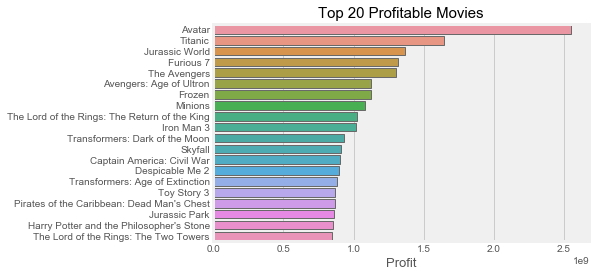

In [44]:
#make a plot which contain top 10 movies which earn highest profit.
#sort the 'Profit' column in decending order and store it in the new dataframe,
info = pd.DataFrame(df_movies['Profit'].sort_values(ascending = False))
info['original_title'] = df_movies['original_title']
data = list(map(str,(info['original_title'])))
x = list(data[:20])
y = list(info['Profit'][:20])

#make a plot usinf pointplot for top 10 profitable movies.
ax = sns.barplot(x=y,y=x)

#setup the figure size
sns.set(rc={'figure.figsize':(10,5)})
#setup the title and labels of the plot.
ax.set_title("Top 20 Profitable Movies",fontsize = 15)
ax.set_xlabel("Profit",fontsize = 13)
sns.set_style("darkgrid")

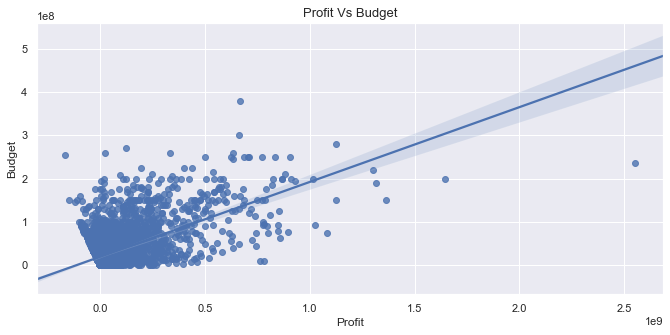

In [45]:
ax = sns.regplot(x=df_movies['Profit'], y=df_movies['budget'],color='b')

#setup the title and the labels of the plot.
ax.set_title("Profit Vs Budget",fontsize=13)
ax.set_xlabel("Profit",fontsize=12)
ax.set_ylabel("Budget",fontsize=12)

#setup the figure size and style sheet of the plot.
sns.set(rc={'figure.figsize':(20,7)})
sns.set_style("whitegrid")


### 1.2.2.1 Average Movie Rating

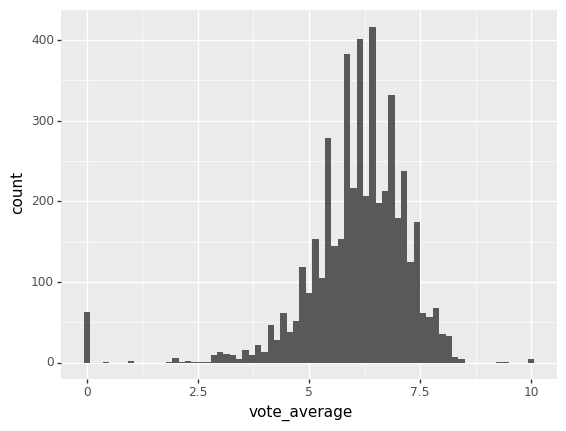

<ggplot: (131809077666)>

In [46]:
ggplot(aes(x='vote_average'), data=df_movies) + \
    geom_histogram()

The Histogram plot shows that the average TMDBscore is between 5-7.5 and the overall average is 6.5.

## 1.2.5 Calculating movies with high and low budget

In [47]:
df_movies['budget'] = df_movies['budget'].replace(0,np.NAN)
find_minmax('budget')

Movie Which Has Highest budget :  Pirates of the Caribbean: On Stranger Tides
Movie Which Has Lowest budget  :  Modern Times


,17,4238
budget,3.8e+08,1
genres,Adventure|Action|Fantasy,Drama|Comedy
homepage,http://disney.go.com/pirates/index-on-stranger...,NaN
id,1865,3082
plot_keywords,sea|captain|mutiny|sword|prime minister|sailin...,factory|ambulance|invention|tramp|great depres...
language,en,en
original_title,Pirates of the Caribbean: On Stranger Tides,Modern Times
overview,Captain Jack Sparrow crosses paths with a woma...,The Tramp struggles to live in modern industri...
popularity,135.414,28.2765
production_companies,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'name': 'United Artists', 'id': 60}, {'name'..."


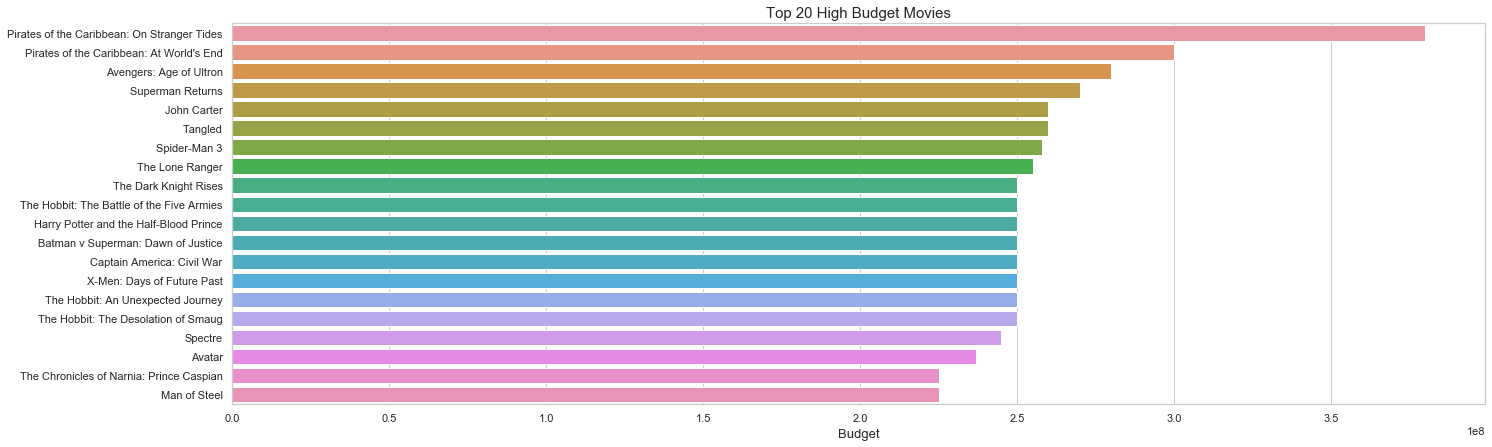

In [48]:
info = pd.DataFrame(df_movies['budget'].sort_values(ascending = False))
info['original_title'] = df_movies['original_title']
data = list(map(str,(info['original_title'])))

#extract the top 10 budget movies data from the list and dataframe.
x = list(data[:20])
y = list(info['budget'][:20])

#plot the figure and setup the title and labels.
ax = sns.barplot(x=y,y=x)
sns.set(rc={'figure.figsize':(10,5)})
ax.set_title("Top 20 High Budget Movies",fontsize = 15)
ax.set_xlabel("Budget",fontsize = 13)
sns.set_style("darkgrid")

##  1.2.6 Analysis of how runtime affect popularity

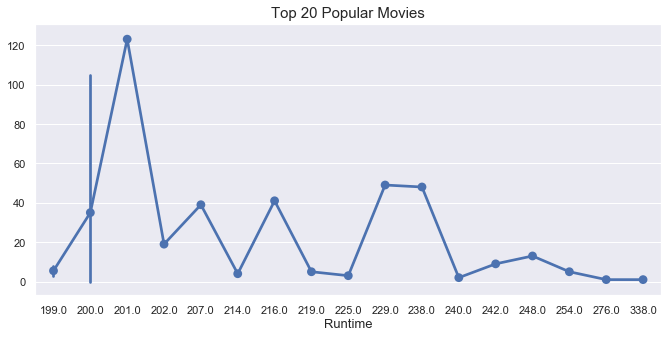

In [49]:
info = pd.DataFrame(df_movies['duration'].sort_values(ascending = False))
info['popularity'] = df_movies['popularity']
data = list(map(int,(info['popularity'])))

#extract the top 10 movies with high revenue data from the list and dataframe.
x = list(data[:20])
y = list(info['duration'][:20])

#make the point plot and setup the title and labels.
ax = sns.pointplot(x=y,y=x)
sns.set(rc={'figure.figsize':(25,5)})
ax.set_title("Top 20 Popular Movies",fontsize = 15)
ax.set_xlabel("Runtime",fontsize = 13)
#sns.set_style("ticks")
sns.set_style("darkgrid")

The plot shows that popularity of movies that have duration of about 3 hours is high and as  the duration increases the popularity decreases

Thus a movie's popluarity also depends on the duration. 

## 1.2.7  Analysis of movie release per year

In [50]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], infer_datetime_format=True)
df_movies['release_day'] = df_movies['release_date'].apply(lambda t: t.day)
df_movies['release_weekday'] = df_movies['release_date'].apply(lambda t: t.weekday())
df_movies['release_month'] = df_movies['release_date'].apply(lambda t: t.month)

# Year was being interpreted as future dates in some cases so I had to adjust some values
df_movies['release_year'] = df_movies['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

In [51]:
df_movies[['release_date','release_day','release_weekday','release_month','release_year']].head()

,release_date,release_day,release_weekday,release_month,release_year
0,2009-12-10,10.0,3.0,12.0,2009.0
1,2007-05-19,19.0,5.0,5.0,2007.0
2,2015-10-26,26.0,0.0,10.0,2015.0
3,2012-07-16,16.0,0.0,7.0,2012.0
4,2012-03-07,7.0,2.0,3.0,2012.0


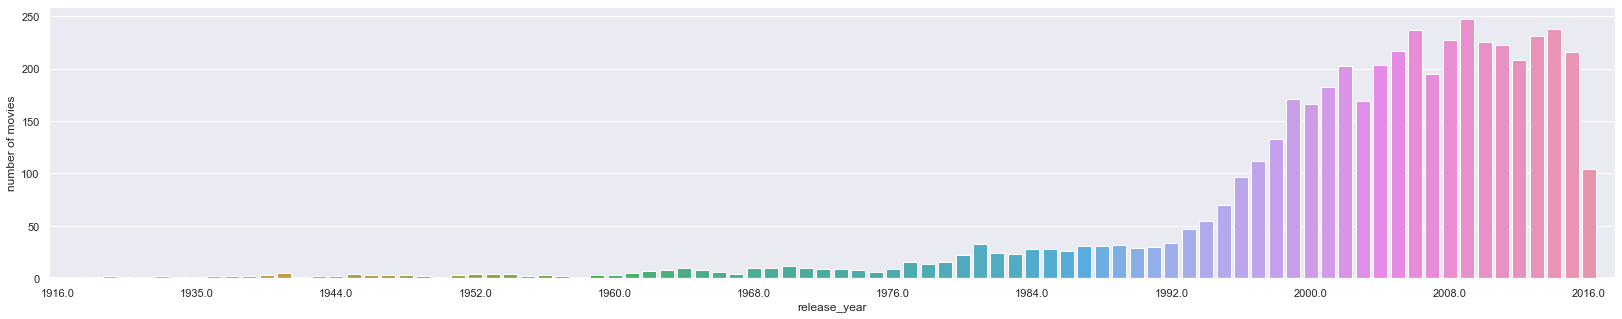

In [52]:
fig = sns.countplot(df_movies.release_year)
fig.set(ylabel='number of movies')
for index, label in enumerate(fig.xaxis.get_ticklabels()):
    if index % 8 != 0:
        label.set_visible(False)

The plot shows that our dataset contains movies released during the year between 2008-2016 has high number of release.

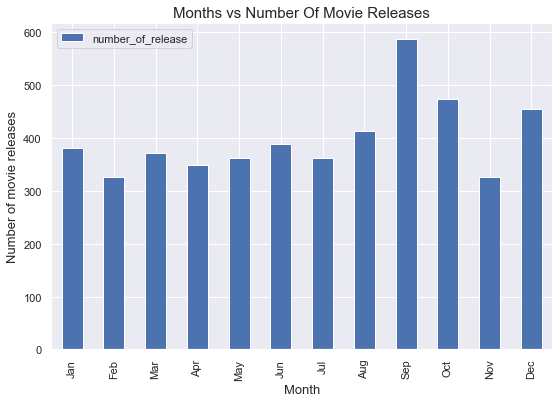

In [53]:
month_release = df_movies['release_date'].dt.month

#count the movies in each month using value_counts().
number_of_release = month_release.value_counts().sort_index()
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
number_of_release = pd.DataFrame(number_of_release)
number_of_release['month'] = months

#change the column name of the new dataframe 'number_of_release'
number_of_release.rename(columns = {'release_date':'number_of_release'},inplace=True)

#plot the bar graph using plot.
number_of_release.plot(x='month',kind='bar',fontsize = 11,figsize=(8,6))

#set the labels and titles of the plot.
plt.title('Months vs Number Of Movie Releases',fontsize = 15)
plt.xlabel('Month',fontsize = 13)
plt.ylabel('Number of movie releases',fontsize = 13)
sns.set_style("darkgrid")

Accordingly the number of movies released during the end of the year is high between 2008-2016.

### 1.2.7 ggplot analysis over popularity vs language

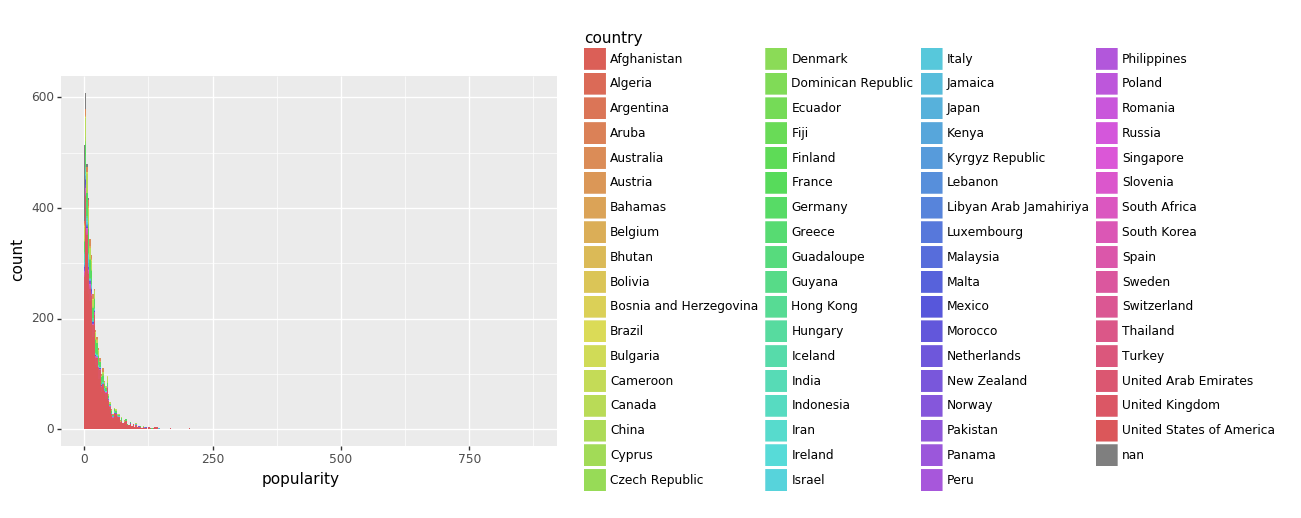

<ggplot: (131809533325)>

In [54]:
ggplot(df_movies, aes(x='popularity', fill='country')) + geom_histogram()

The plot explaines that Most of the movies released in English are highly popular 

## 2 Budget vs Revenue Analysis

In [55]:
df_movies['log_gross'] = np.log(df_movies['gross'])

In [56]:
median = df_movies["budget"].median()
df_movies["budget"].fillna(median, inplace=True) 

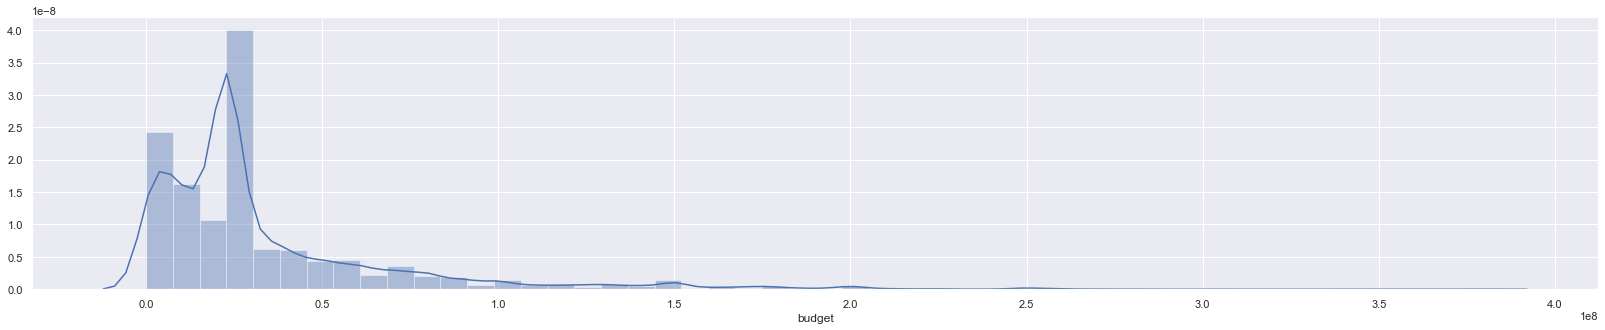

In [57]:
sns.distplot(df_movies['budget'])

In [58]:
df_movies['log_budget'] = np.log(df_movies['budget'])

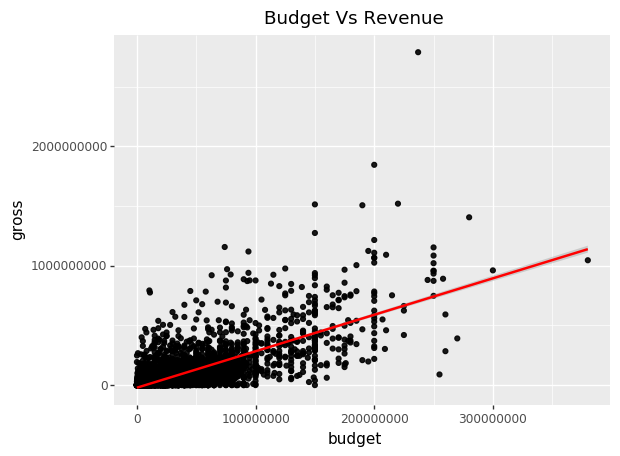

<ggplot: (-9223371905044266983)>

In [59]:
ggplot(aes(x = 'budget', y = 'gross'), data = df_movies) +\
  geom_point(alpha = 0.9, position =  "jitter") +\
  geom_smooth(method = 'lm', color = 'red') +\
  ylab('gross') +\
  xlab('budget') +\
    ggtitle('Budget Vs Revenue')

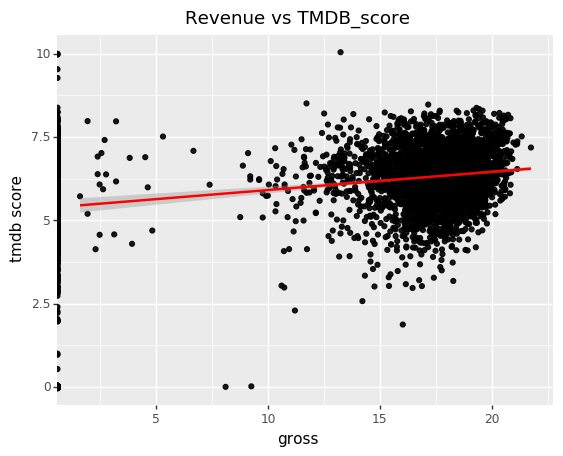

<ggplot: (131810521927)>

In [60]:
ggplot(aes(x = 'log_gross', y = 'vote_average'), data = df_movies) +\
  geom_point(alpha = 0.9, position =  "jitter") +\
  geom_smooth(method = 'lm', color = 'red') +\
  ylab('tmdb score') +\
  xlab('gross') +\
   ggtitle("Revenue vs TMDB_score")

## 2.1 Desity Plot analysis on Budget 

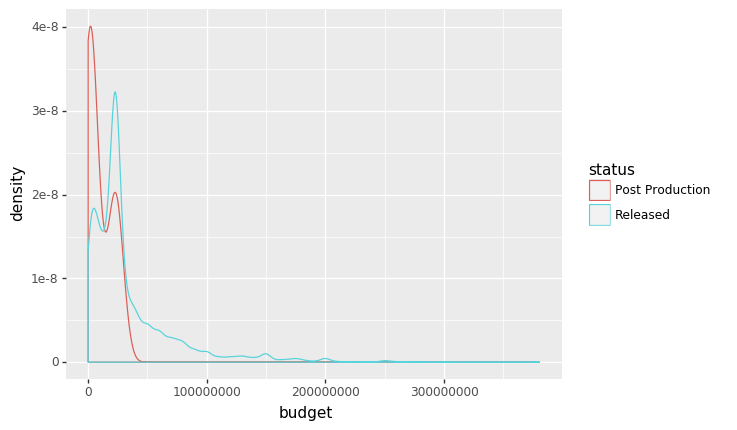

<ggplot: (131809623507)>

In [61]:
ggplot(df_movies, aes(x='budget', color='status')) + \
    geom_density()


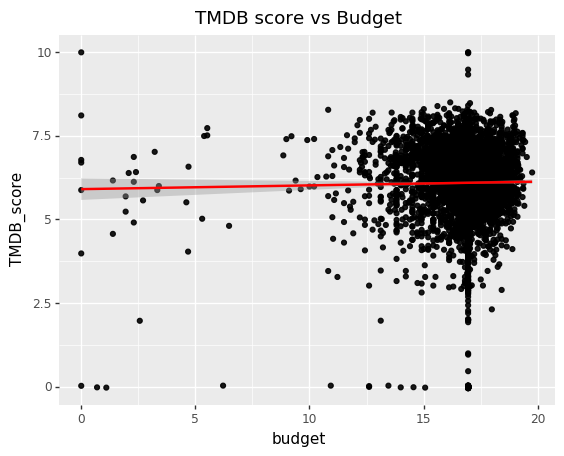

<ggplot: (131810696049)>

In [62]:
ggplot(aes(x = 'log_budget', y = 'vote_average'), data = df_movies) +\
  geom_point(alpha = 0.9, position =  "jitter") +\
  geom_smooth(method = 'lm', color = 'red') +\
  ylab('TMDB_score') +\
  xlab('budget') +\
   ggtitle('TMDB score vs Budget')


## 3. Correlation Analysis

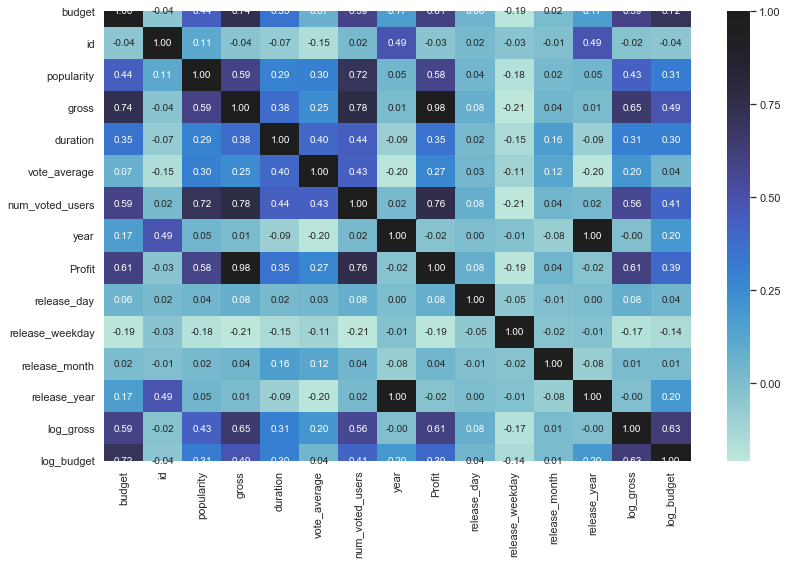

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
corrmat = df_movies.dropna(axis=0, how='any').corr()

ax = sns.heatmap(corrmat, annot=True, fmt='.2f', annot_kws={'size': 10}, center=1)
plt.show()

A barplot on Movies released in cuntry vs their popularity. 

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 31 columns):
budget                  4803 non-null float64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
plot_keywords           4803 non-null object
language                4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null datetime64[ns]
gross                   4803 non-null int64
duration                4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
movie_title             4803 non-null object
vote_average            4803 non-null float64
num_voted_users         4803

## Linear Model

In [66]:
data = pd.read_csv("tmdb_5000_movies.csv")
dict_columns = [ 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'keywords']
data = text_to_dict(data)

data['list_of_genres'] = list(data['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
data = data.drop(['genres'], axis=1)
#Production_companies
data['production_companies_names'] = list(data['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
data = data.drop(['production_companies'], axis=1)
#production_countries
data['production_countries_names'] = list(data['production_countries'].apply(lambda x: [i['iso_3166_1'] for i in x] if x != {} else []).values)
data = data.drop(['production_countries'], axis=1)
#spoken_languages
data['spoken_languages_codes'] = list(data['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
data = data.drop(['spoken_languages'], axis=1)
#Keywords
data['Keyword_names'] = (data['keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
data = data.drop(['keywords'], axis=1)

In [67]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#original_title
le.fit(list(data['original_title'].fillna('')))
data['original_title'] = le.transform(data['original_title'].fillna('').astype(str))
#production_companies_names
le.fit(list(data['production_companies_names'].fillna('').astype(str)))
data['production_companies_names'] = le.transform(data['production_companies_names'].fillna('').astype(str))
#production_countries_names
le.fit(list(data['production_countries_names'].fillna('').astype(str)))
data['production_countries_names'] = le.transform(data['production_countries_names'].fillna('').astype(str))
#spoken_languages_codes
le.fit(list(data['spoken_languages_codes'].fillna('').astype(str)))
data['spoken_languages_codes'] = le.transform(data['spoken_languages_codes'].fillna('').astype(str))
#Keyword_names
le.fit(list(data['Keyword_names'].fillna('').astype(str)))
data['Keyword_names'] = le.transform(data['Keyword_names'].fillna('').astype(str))
#Keyword_names
le.fit(list(data['list_of_genres'].fillna('').astype(str)))
data['list_of_genres'] = le.transform(data['list_of_genres'].fillna('').astype(str))

In [68]:
data = data[['budget','popularity','runtime','revenue','list_of_genres','production_countries_names','status']]

In [69]:
data.isna().sum()

budget                        0
popularity                    0
runtime                       2
revenue                       0
list_of_genres                0
production_countries_names    0
status                        0
dtype: int64

In [70]:
median = data["runtime"].median()
data["runtime"].fillna(median, inplace=True) 

In [71]:
data=data.dropna()
data

,budget,popularity,runtime,revenue,list_of_genres,production_countries_names,status
0,237000000,150.437577,162.0,2787965087,61,439,Released
1,300000000,139.082615,169.0,961000000,338,464,Released
2,245000000,107.376788,148.0,880674609,41,298,Released
3,250000000,112.312950,165.0,1084939099,131,464,Released
4,260000000,43.926995,132.0,284139100,75,464,Released
...,...,...,...,...,...,...,...
4798,220000,14.269792,81.0,2040920,139,373,Released
4799,9000,0.642552,85.0,0,534,468,Released
4800,0,1.444476,120.0,0,478,464,Released
4801,0,0.857008,98.0,0,1174,422,Released


In [72]:
one_hot = pd.get_dummies(data['status'])
data = data.drop('status', axis=1)
data = data.join(one_hot)

In [73]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(data, test_size = 0.2, random_state = 21)

#classifying the predictors and target variables as X and Y
X_train = training_set.iloc[:,[1,2,3,4,5,6,7,8]].values
Y_train = training_set.iloc[:,0].values
Y_train=Y_train.astype('int')
X_val = validation_set.iloc[:,[1,2,3,4,5,6,7,8]].values
Y_val = validation_set.iloc[:,0].values
Y_val=Y_val.astype('int')

In [74]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_tr_scale=scaler.fit_transform(X_train)
X_te_scale=scaler.fit_transform(X_val)

X_tr_scale[:,:5]

array([[-0.17129435, -0.58743918,  0.04202331,  1.37447565, -2.1988253 ],
       [-0.12990475,  0.82235331, -0.26527013,  0.62279132, -1.51787792],
       [-0.33627525,  1.45903378, -0.30758369, -0.76833487, -0.66095537],
       ...,
       [-0.21387542, -0.86030225, -0.50027873,  1.79963647, -0.58444442],
       [ 0.67528139,  0.32210436,  0.7053271 , -1.45539475,  0.60912627],
       [-0.19653093,  0.6404446 , -0.20077208,  0.62279132, -1.25008962]])

In [75]:
from sklearn import preprocessing
from sklearn import pipeline

pipeline_tr = pipeline.Pipeline([ ('scaler',StandardScaler())])

pipe=pipeline_tr.fit_transform(data)
pipe

array([[ 5.10718073,  4.05318294,  2.43865209, ..., -0.025     ,
         0.04084611, -0.03228159],
       [ 6.65440223,  3.69625836,  2.74831795, ..., -0.025     ,
         0.04084611, -0.03228159],
       [ 5.3036533 ,  2.69963777,  1.81932035, ..., -0.025     ,
         0.04084611, -0.03228159],
       ...,
       [-0.71331921, -0.63017043,  0.58065689, ..., -0.025     ,
         0.04084611, -0.03228159],
       [-0.71331921, -0.64863652, -0.39257869, ..., -0.025     ,
         0.04084611, -0.03228159],
       [-0.71331921, -0.61491246, -0.74648254, ..., -0.025     ,
         0.04084611, -0.03228159]])

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [77]:
def rmse(a, b):
    return np.sqrt(np.mean((a-b)**2))
pd.options.display.max_columns = None
np.random.seed(0)

### Linear Regression

In [78]:
from sklearn.linear_model import LinearRegression

linear=LinearRegression()
linear.fit(X_tr_scale,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
y_pred=linear.predict(X_te_scale)

In [80]:
print(rmse(Y_val,y_pred))

25796657.179329347


In [81]:
print(linear.score(X_te_scale,Y_val))

0.6153303373879935


In [82]:
predicteddf = pd.DataFrame({'Actual': Y_val.flatten(), 'Predicted': y_pred.flatten()})
predicteddf.sample(5)

,Actual,Predicted
55,32000000,3.415353e+07
852,50000000,4.894817e+07
14,25000000,2.763580e+07
553,2000000,1.430441e+07
141,3500000,1.643396e+07


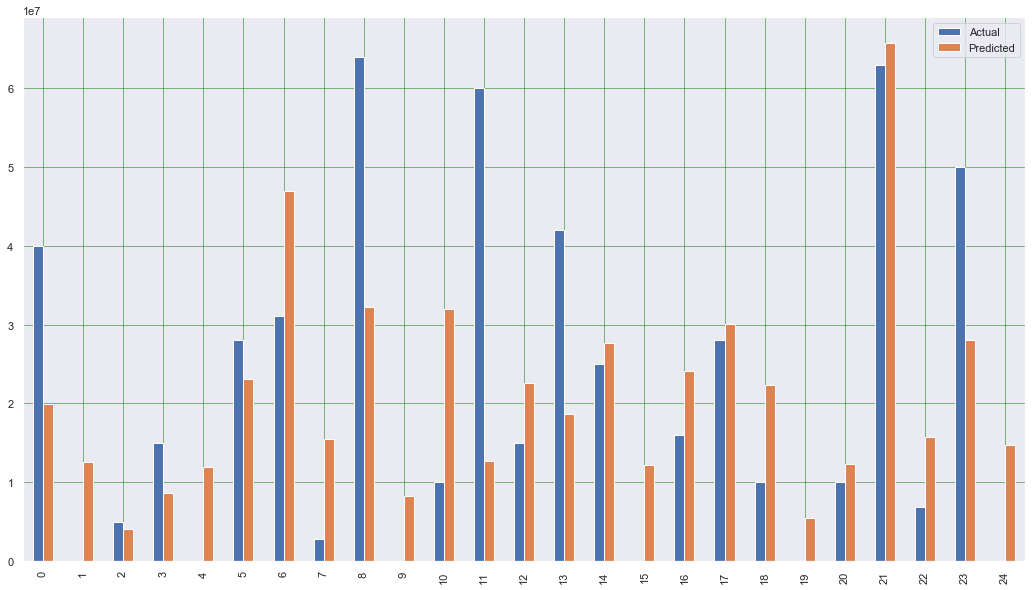

In [83]:
plotresult = predicteddf.head(25)
plotresult.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [84]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_val, y_pred)))

Mean Absolute Error: 17667662.567536313
Mean Squared Error: 665467521627844.4
Root Mean Squared Error: 25796657.179329347


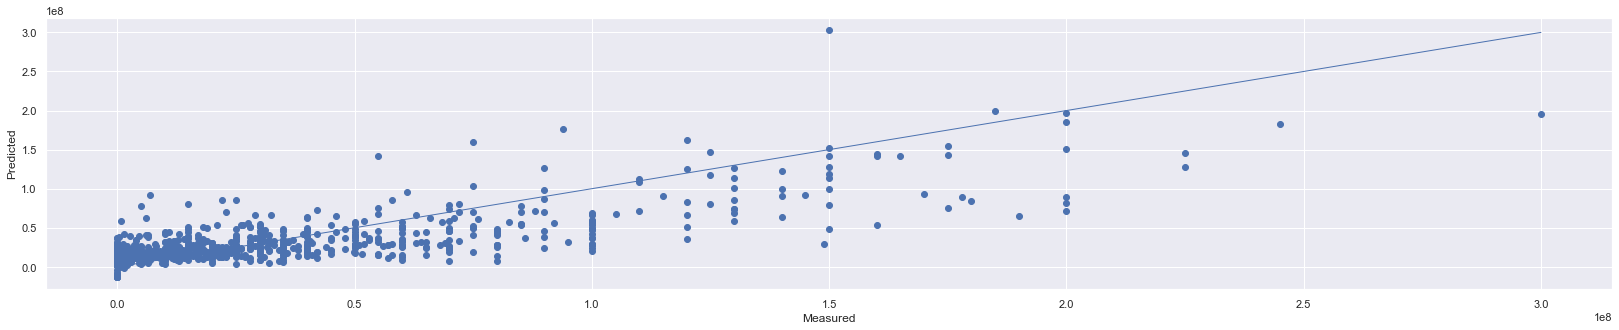

In [85]:
fig, ax = plt.subplots()
ax.scatter(Y_val, y_pred)
ax.plot([Y_val.min(), Y_val.max()], [Y_val.min(),Y_val.max()], lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### RandomForest Regressor

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
param_grid = [{'n_estimators': [4, 5, 10, 20, 50]}]

rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search_rf.fit(X_tr_scale, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    5.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    6.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_estimators': [4, 5, 10, 20, 5

In [87]:
grid_search_rf.best_params_

{'n_estimators': 50}

In [88]:
grid_search_rf.best_score_

0.5827640702568018

In [89]:
y_pred_t=grid_search_rf.predict(X_te_scale)

In [90]:
print(rmse(Y_val,y_pred_t))

24477875.49081056


### LGBTM Regressor

In [91]:
from lightgbm import LGBMRegressor

In [92]:
def rmsle(y_true, y_pred):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [93]:
lr = LGBMRegressor(boosting_type='dart',num_leaves=20,max_depth=-1,min_data_in_leaf=20, learning_rate=0.2,n_estimators=500,subsample_for_bin=200000,
                   class_weight=None,min_split_gain=0.0,min_child_weight=0.001,subsample=0.1,subsample_freq=0,colsample_bytree=0.75,reg_alpha=0.0,reg_lambda=0.0,
                   random_state=101,n_jobs=-1)
lr.fit(X_tr_scale, Y_train,eval_set=[(X_te_scale, Y_val)],eval_metric=rmsle,verbose=False)
y_pred = lr.predict(X_te_scale, num_iteration=lr.best_iteration_)

In [94]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_val, y_pred))
print('MSE:', metrics.mean_squared_error(Y_val, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val, y_pred)))
print('RMSLE:', rmsle(Y_val, y_pred))

MAE: 15776227.714008523
MSE: 602674624658963.8
RMSE: 24549432.26754875
RMSLE: ('rmsle', nan, False)


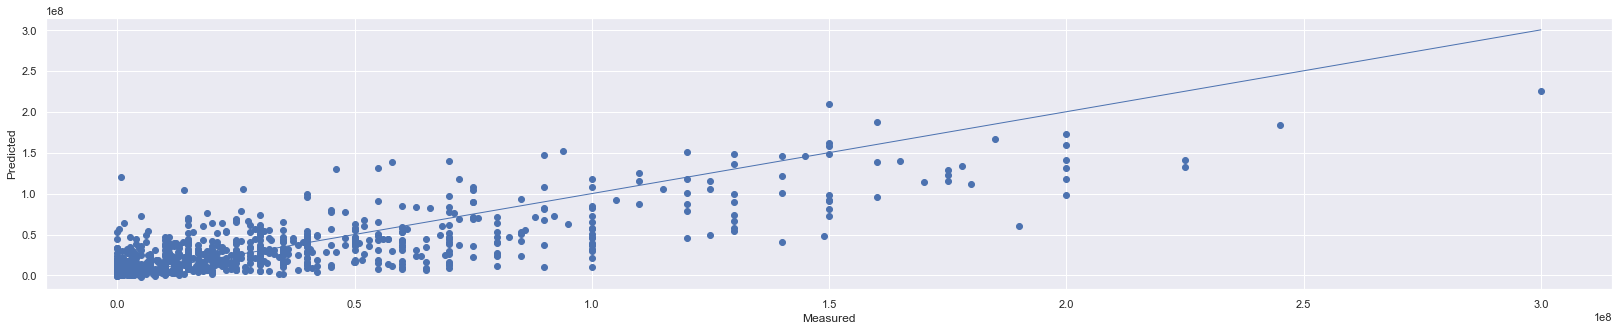

In [95]:
fig, ax = plt.subplots()
ax.scatter(Y_val, y_pred)
ax.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [96]:
print(lr.score(X_te_scale,Y_val))

0.651627409305739


### 4. Classification Model 

Data Cleaning and Processing

### DecisionTree

In [97]:
data = df_movies[['budget','gross','country','num_voted_users']]


In [98]:
one_hot = pd.get_dummies(data['country'])
data = data.drop('country', axis=1)
data = data.join(one_hot)

In [99]:
data.dtypes

budget                      float64
gross                         int64
num_voted_users               int64
Afghanistan                   uint8
Algeria                       uint8
                             ...   
Thailand                      uint8
Turkey                        uint8
United Arab Emirates          uint8
United Kingdom                uint8
United States of America      uint8
Length: 73, dtype: object

In [100]:
data['gross']

0       2787965087
1        961000000
2        880674609
3       1084939099
4        284139100
           ...    
4798       2040920
4799             0
4800             0
4801             0
4802             0
Name: gross, Length: 4803, dtype: int64

Revenue is classified into 4 classes based on their distribution

In [101]:
def generate_label(df):
    conditions = [
        (df['gross'] <= 1000000),
        (df['gross'] > 1000000) & (df['gross'] <= 25000000),
        (df['gross'] > 25000000) & (df['gross'] <= 100000000),
        (df['gross'] > 100000000) & (df['gross'] <= 300000000)]
    choices=[0,1,2,3]
    df['label']=np.select(conditions, choices, default=4)
generate_label(data)

[1620, 947, 1110, 781, 345]


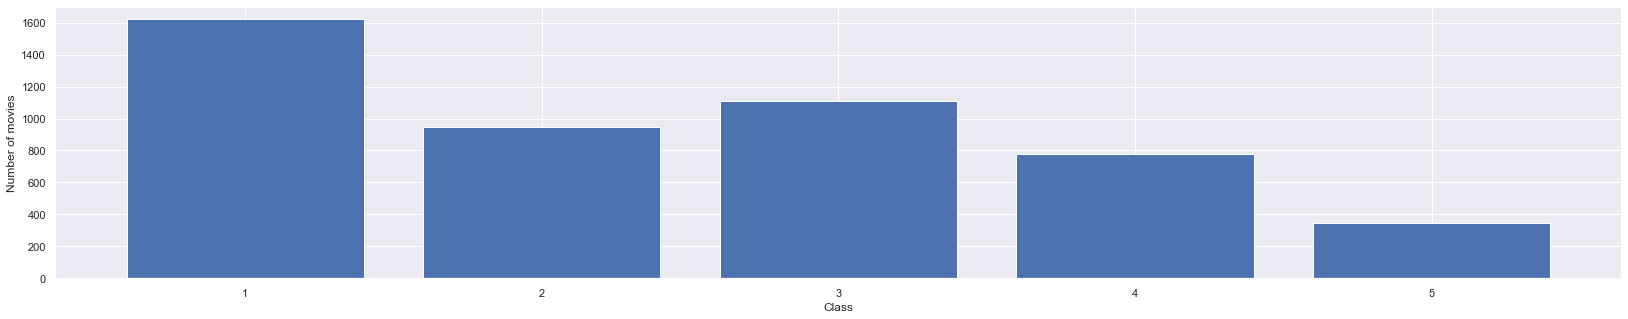

In [102]:
bin_classes = [0]*5
for label in data['label']:
    bin_classes[int(label)]+=1
print(bin_classes)
plt.bar(np.arange(5), bin_classes)
plt.xticks(np.arange(5), np.arange(1,10))
plt.xlabel('Class')
plt.ylabel('Number of movies')
plt.show()

In [103]:
data.isna().sum()

budget                      0
gross                       0
num_voted_users             0
Afghanistan                 0
Algeria                     0
                           ..
Turkey                      0
United Arab Emirates        0
United Kingdom              0
United States of America    0
label                       0
Length: 74, dtype: int64

In [104]:
data=data.dropna()

In [105]:
data = data.drop(columns=['gross'])


In [106]:
data.to_csv("new_data.csv", index=False)

In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("new_data.csv")
all_data = data.values
#all_data = np.delete(all_data, [0,3], axis=1)

### 4.1 PreProcessing

In [108]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# normalize budget, release year, runtime, grosses
normalized_values = scaler.fit_transform(all_data[:,1:7])
# stack them together
all_data = np.hstack((all_data[:,:1], normalized_values, all_data[:,7:]))

In [109]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_data[:, :-1], all_data[:,-1], 
            test_size=0.2, shuffle=True, random_state=418)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3842, 72)
(3842,)
(961, 72)
(961,)


In [110]:
set(y_train)

{0.0, 1.0, 2.0, 3.0, 4.0}

[313, 179, 239, 157, 73]


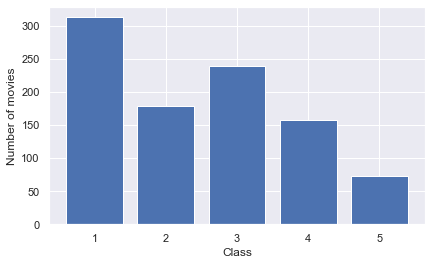

In [111]:
bin_classes = [0]*5
for label in y_test:
    bin_classes[int(label)]+=1
print(bin_classes)
plt.bar(np.arange(5), bin_classes)
plt.xticks(np.arange(5), np.arange(1,10))
plt.xlabel('Class')
plt.ylabel('Number of movies')
plt.show()

### 4.2 DecisionTreeClassifier

In [112]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV


clf = DecisionTreeClassifier(criterion='entropy',max_depth=3)
clf = clf.fit(x_train, y_train)

In [113]:
from sklearn.metrics import accuracy_score

y_pred_t = clf.predict(x_test)
accuracy_score(y_test, y_pred_t)

0.5483870967741935

In [114]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [115]:
print(confusion_matrix(y_test, y_pred_t))
print(classification_report(y_test, y_pred_t))

[[277   0  35   1   0]
 [ 91   0  75  12   1]
 [ 53   0 135  51   0]
 [  2   0  66  61  28]
 [  0   0   4  15  54]]
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75       313
         1.0       0.00      0.00      0.00       179
         2.0       0.43      0.56      0.49       239
         3.0       0.44      0.39      0.41       157
         4.0       0.65      0.74      0.69        73

    accuracy                           0.55       961
   macro avg       0.43      0.52      0.47       961
weighted avg       0.44      0.55      0.49       961



## 4.3 KNeighborsClassifier

[[239  50  23   1   0]
 [ 66  69  39   5   0]
 [ 40  60 102  34   3]
 [  6  13  55  72  11]
 [  0   0  11  33  29]]
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       313
         1.0       0.36      0.39      0.37       179
         2.0       0.44      0.43      0.43       239
         3.0       0.50      0.46      0.48       157
         4.0       0.67      0.40      0.50        73

    accuracy                           0.53       961
   macro avg       0.53      0.49      0.50       961
weighted avg       0.53      0.53      0.53       961

[[244  42  24   3   0]
 [ 64  65  42   8   0]
 [ 33  43 120  41   2]
 [  4  12  57  68  16]
 [  0   0  11  31  31]]
              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       313
         1.0       0.40      0.36      0.38       179
         2.0       0.47      0.50      0.49       239
         3.0       0.45      0.43      0.44       157
        

Text(0, 0.5, 'Accuracy')

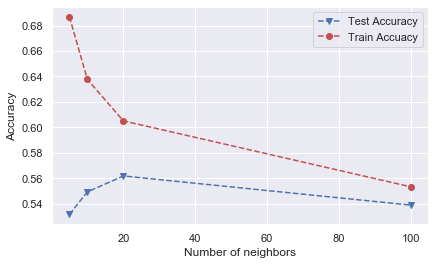

In [116]:
from sklearn.neighbors import KNeighborsClassifier

numNeighbors = [ 5, 10, 20, 100]
testAcc = []
trainAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf.fit(x_train, y_train)
    knn_pred = clf.predict(x_test)
    knn_pred_train = clf.predict(x_train)
    #print(knn_pred)
    testAcc.append(accuracy_score(y_test, knn_pred))
    trainAcc.append(accuracy_score(y_train,knn_pred_train))
    print(confusion_matrix(y_test, knn_pred))
    print(classification_report(y_test, knn_pred))

plt.plot(numNeighbors, testAcc,'bv--',numNeighbors, trainAcc, 'ro--')
plt.legend(['Test Accuracy','Train Accuacy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

### 4.4 RandomForestClassifier

[[238  47  25   3   0]
 [ 58  73  42   6   0]
 [ 31  62 103  41   2]
 [  5  13  55  68  16]
 [  1   1   6  22  43]]
              precision    recall  f1-score   support

         0.0       0.71      0.76      0.74       313
         1.0       0.37      0.41      0.39       179
         2.0       0.45      0.43      0.44       239
         3.0       0.49      0.43      0.46       157
         4.0       0.70      0.59      0.64        73

    accuracy                           0.55       961
   macro avg       0.54      0.52      0.53       961
weighted avg       0.55      0.55      0.55       961

[[237  45  28   3   0]
 [ 59  67  46   6   1]
 [ 29  65  96  45   4]
 [  4  11  53  73  16]
 [  0   1   7  17  48]]
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74       313
         1.0       0.35      0.37      0.36       179
         2.0       0.42      0.40      0.41       239
         3.0       0.51      0.46      0.49       157
        

Text(0, 0.5, 'Accuracy')

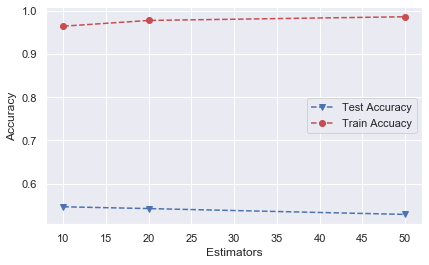

In [117]:
from sklearn.ensemble import RandomForestClassifier

estimators = [10, 20, 50]
testAcc = []
trainAcc = []

for k in estimators:
    clf = RandomForestClassifier(n_estimators=k)
    clf.fit(x_train, y_train)
    rand_pred = clf.predict(x_test)
    rand_pred_train = clf.predict(x_train)
    #print(rand_pred)
    testAcc.append(accuracy_score(y_test, rand_pred))
    trainAcc.append(accuracy_score(y_train,rand_pred_train))
    print(confusion_matrix(y_test, rand_pred))
    print(classification_report(y_test, rand_pred))

plt.plot(estimators, testAcc,'bv--',estimators, trainAcc, 'ro--')
plt.legend(['Test Accuracy','Train Accuacy'])
plt.xlabel('Estimators')
plt.ylabel('Accuracy')

### 4.5 MLPClassifier

[[313   0   0   0   0]
 [179   0   0   0   0]
 [239   0   0   0   0]
 [157   0   0   0   0]
 [ 73   0   0   0   0]]
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.49       313
         1.0       0.00      0.00      0.00       179
         2.0       0.00      0.00      0.00       239
         3.0       0.00      0.00      0.00       157
         4.0       0.00      0.00      0.00        73

    accuracy                           0.33       961
   macro avg       0.07      0.20      0.10       961
weighted avg       0.11      0.33      0.16       961

[[  0   5   1   0 307]
 [  0   0   0   0 179]
 [  0   0   0   0 239]
 [  0   0   0   0 157]
 [  0   0   0   0  73]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       313
         1.0       0.00      0.00      0.00       179
         2.0       0.00      0.00      0.00       239
         3.0       0.00      0.00      0.00       157
        

Text(0, 0.5, 'Accuracy')

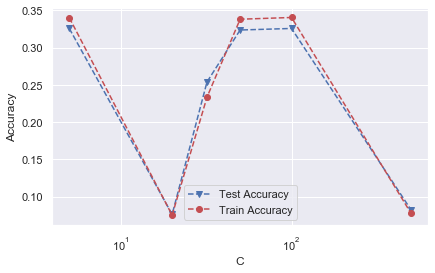

In [118]:
from sklearn.neural_network import MLPClassifier

C = [5, 20, 32, 50, 100, 500]

LRtestAcc = []
LRtrainAcc = []

for param in C:
    classifier = MLPClassifier(hidden_layer_sizes=param, max_iter=50,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(x_train,y_train)
    log_reg_pred_train = classifier.predict(x_train)
    log_reg_pred = classifier.predict(x_test)
    #print(log_reg_pred)
    LRtestAcc.append(accuracy_score(y_test, log_reg_pred))
    LRtrainAcc.append(accuracy_score(y_train,log_reg_pred_train))
    print(confusion_matrix(y_test, log_reg_pred))
    print(classification_report(y_test, log_reg_pred))

    

plt.plot(C, LRtestAcc,'bv--',C,LRtrainAcc,'ro--')
plt.legend(['Test Accuracy','Train Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')  

## 4.6 SVM

[[212  60  37   3   1]
 [ 42  76  46  15   0]
 [ 23  61 125  27   3]
 [  6  22  57  62  10]
 [  0   7   9  33  24]]
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71       313
         1.0       0.34      0.42      0.38       179
         2.0       0.46      0.52      0.49       239
         3.0       0.44      0.39      0.42       157
         4.0       0.63      0.33      0.43        73

    accuracy                           0.52       961
   macro avg       0.52      0.47      0.48       961
weighted avg       0.54      0.52      0.52       961

[[212  63  35   3   0]
 [ 42  85  39  13   0]
 [ 23  72 113  28   3]
 [  8  22  51  67   9]
 [  0   7   9  31  26]]
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       313
         1.0       0.34      0.47      0.40       179
         2.0       0.46      0.47      0.47       239
         3.0       0.47      0.43      0.45       157
        

Text(0, 0.5, 'Accuracy')

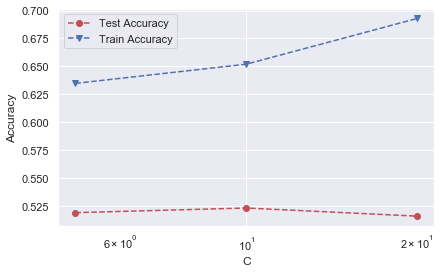

In [119]:
from sklearn.svm import SVC
C = [5,10,20]
 

SVMLtestAcc = []
SVMLtrainAcc = []



for param in C:
    clf = SVC(C=param,kernel='rbf',gamma='auto')
    clf.fit(x_train,y_train)
    svml_pred = clf.predict(x_test)
    svml_pred_train = clf.predict(x_train)
    #print(svml_pred)
    SVMLtestAcc.append(accuracy_score(y_test, svml_pred))
    SVMLtrainAcc.append(accuracy_score(y_train,svml_pred_train))
    print(confusion_matrix(y_test, svml_pred))
    print(classification_report(y_test, svml_pred))
plt.plot(C, SVMLtestAcc,'ro--', C,SVMLtrainAcc,'bv--')
plt.legend(['Test Accuracy','Train Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')  